In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

In [2]:
import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import tifffile as tiff
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.blob_detection import *
from skimage import io
#import curve_fit 
from scipy.optimize import curve_fit
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.simulate_foci as simulate_foci
import src.SMT_Analysis_BP.helpers.simulate_cells as simulate_cells
import src.SMT_Analysis_BP.helpers.SMT_converters as smt
import src.SMT_Analysis_BP.helpers.smallestenclosingcircle as smallestenclosingcircle
#import convexhull
from scipy.spatial import ConvexHull

In [3]:
SAVE = False

In [4]:
initial_dict = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([2,2]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])  
}
cell_parms = {
    "diffusion_coefficients":np.array(list(0.45*np.ones(1000))),
    "initials": initial_dict,
    "num_tracks":1000,
    "track_type":"fbm",
    "hursts":np.array(list(0.2*np.ones(1000))),
    "dims":(200,200),
    "movie_frames":500,
    "cell_space":np.array([80,120,90,105])
}     
global_sim_params = {
    "track_length_mean":1,
    "track_distribution":"constant",
    "exposure_time":20,#ms same as frame_time
    "base_noise":140,
    "point_intensity":20,
    "psf_sigma":1.,
    "frame_time":20,#ms
    "pixel_size":130,
    "axial_function":"exponential",
    "density_dif": 5
}

cell_sim = simulate_cells.Simulate_cells(cell_parms,global_sim_params)
a = cell_sim.get_cell()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-08 05:44:46.026411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-08 05:44:46.026581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

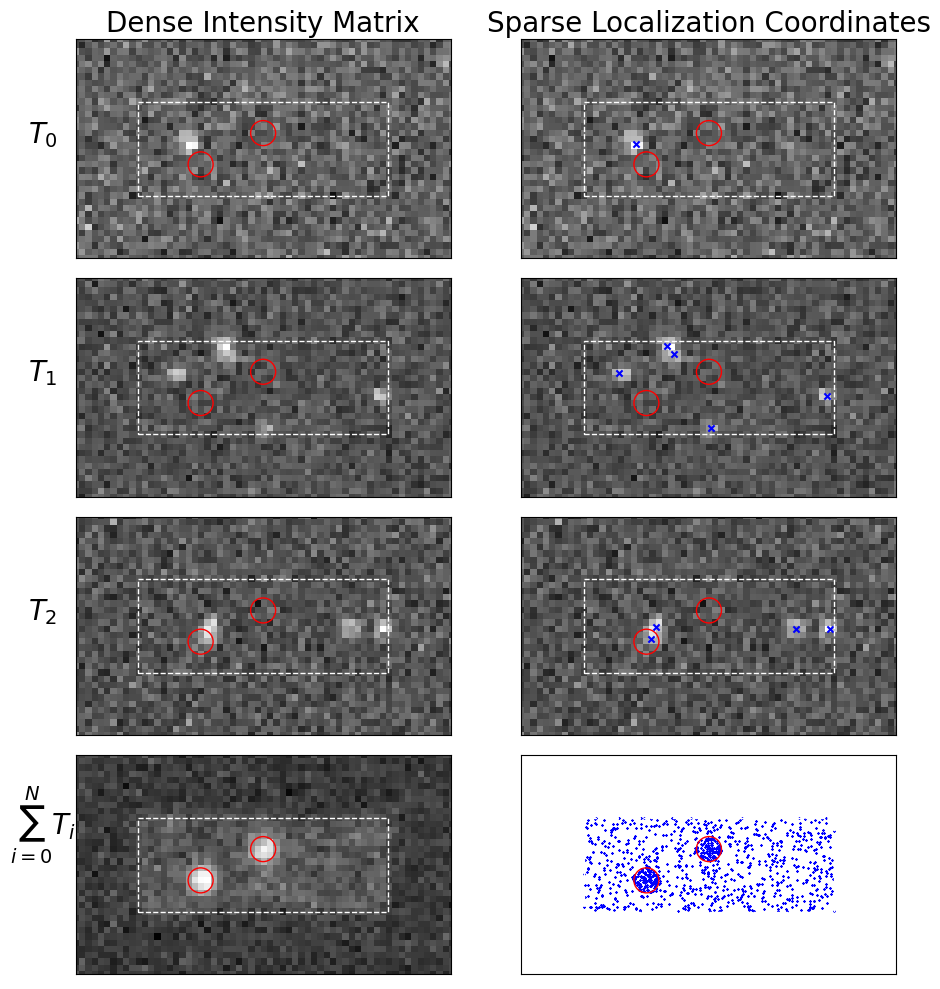

In [ ]:
#make a figure with 4X2 subplots
plt.clf()
fig, ax = plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
#plot the cell for each of the first 6 subplots
for i in range(6):
    #if the subplots are the same row plot the same cell
    if i<2:
        ax[i].imshow(a['map'][0],cmap="gray")
        if i%2==1:
            ax[i].scatter(np.array(a['points_per_frame']['0'])[:,0],np.array(a['points_per_frame']['0'])[:,1],c='b',s=20,marker='x')
    #if the subplots are the same row plot the same cell
    elif i<4:
        ax[i].imshow(a['map'][1],cmap="gray")
        if i%2==1:
            ax[i].scatter(np.array(a['points_per_frame']['1'])[:,0],np.array(a['points_per_frame']['1'])[:,1],c='b',s=20,marker='x')
    #if the subplots are the same row plot the same cell
    else:
        ax[i].imshow(a['map'][5],cmap="gray")
        if i%2==1:
            ax[i].scatter(np.array(a['points_per_frame']['5'])[:,0],np.array(a['points_per_frame']['5'])[:,1],c='b',s=20,marker='x')


#plot the sum of all maps in the last two subplots
ax[6].imshow(np.sum(a['map'],axis=0),cmap="gray")
#ax[7].imshow(np.sum(a['map'],axis=0),cmap="gray")
#make the ax[7] aspect ratio equal
ax[7].set_aspect('equal')
#for the last one plot all the points
for values in a['points_per_frame'].values():
    if len(values)>0:
        ax[7].scatter(np.array(values)[:,0],np.array(values)[:,1],c='b',s=1,marker='x')


#set the x and y lims for all subplots to be around the cell space +- 10
for i in range(8):
    #remove the ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    ax[i].set_xlim(cell_parms["cell_space"][0]-10,cell_parms["cell_space"][1]+10)
    ax[i].set_ylim(cell_parms["cell_space"][2]-10,cell_parms["cell_space"][3]+10)
    #plot the cell outline as a rectange defined by the cell_space
    rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
    ax[i].add_artist(rect)
    #plot the foci as a circle with center and radius defined by the initial centers and scale
    for j in range(len(initial_dict["initial_centers"])):
        circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-')
        ax[i].add_artist(circle)

#on the left side of the figure add the labels for the subplots as T_{0} to T_{3} and the last one as sum T_{i} over N in latex
ax[0].set_ylabel(r"$T_{0}$", rotation=0, labelpad=20, fontsize=20)
ax[2].set_ylabel(r"$T_{1}$", rotation=0, labelpad=20, fontsize=20)
ax[4].set_ylabel(r"$T_{2}$", rotation=0, labelpad=20, fontsize=20)
ax[6].set_ylabel(r"$\sum_{i=0}^{N}T_{i}$", rotation=0, labelpad=20, fontsize=20)
#for the top row add the title for each column as "Scale Space" and "DBSCAN"
ax[0].set_title("Dense Intensity Matrix",fontsize=20)
ax[1].set_title("Sparse Localization Coordinates",fontsize=20)

#show the labels
plt.tight_layout()
#save to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_2/DBSCAN_SS_Inputs
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_2/DBSCAN_SS_Inputs/Example_Inputs.svg",format='svg',dpi=200)
plt.show()


<Figure size 640x480 with 0 Axes>

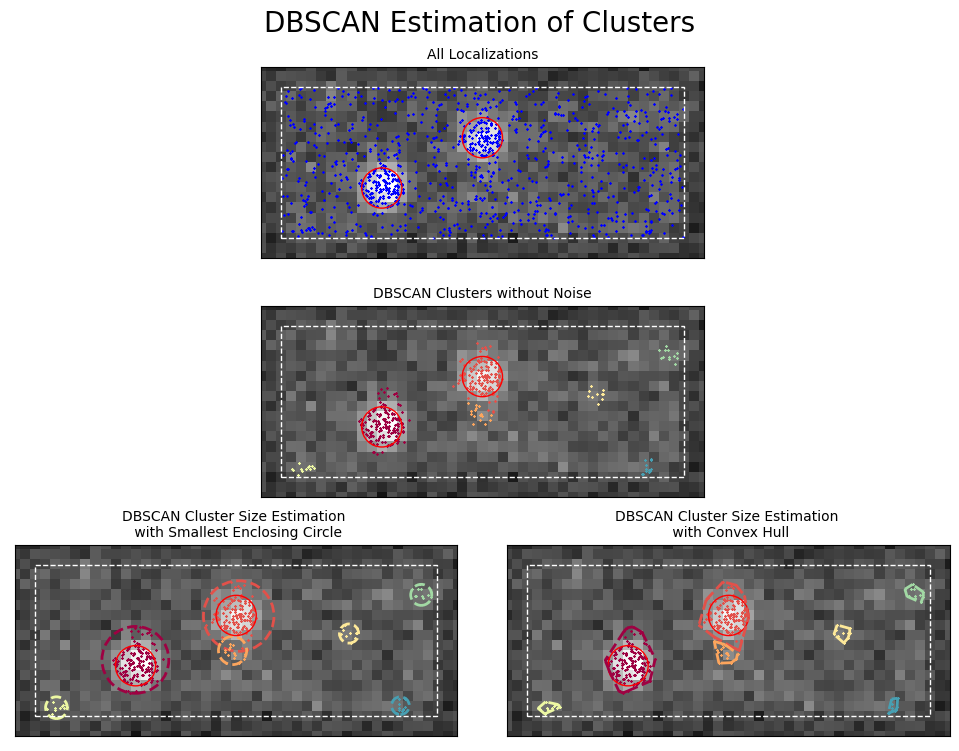

In [6]:
#perform DBSCAN on the points in the cell
from sklearn.cluster import DBSCAN
#make a list of all the points in the cell
points = []
for values in a['points_per_frame'].values():
    points.extend(values)
#convert the list to a numpy array
points = np.array(points)
#perform DBSCAN on the points
db = DBSCAN(eps=1, min_samples=10).fit(points)
#make a list of all the labels
labels = db.labels_
#make a list of all the unique labels
unique_labels = set(labels)
#make a list of all the colors
colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]

#plot the results of DBSCAN
plt.clf()
#make a figure with 4 subplots with the first row as one plot and the second row as 1 plot and the last row as 2 plots
#use GridSpec to make the subplots
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(4, 2)

#make the first subplot over 1,1
ax1 = fig.add_subplot(gs[0, :])
#make the second subplot over 1,2
ax2 = fig.add_subplot(gs[1, :])
#make the third subplot over 2,1
ax3 = fig.add_subplot(gs[2, 0])
#make the fourth subplot over 2,2
ax4 = fig.add_subplot(gs[2, 1])


#first subplot is the points without DBSCAN 
#add the sum of the map to the first subplot
ax1.imshow(np.sum(a['map'],axis=0),cmap="gray")

ax1.scatter(points[:,0],points[:,1],c='b',s=1,marker='x')
#plot the cell outline as a rectange defined by the cell_space
rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
ax1.add_artist(rect)
#plot the foci as a circle with center and radius defined by the initial centers and scale
for j in range(len(initial_dict["initial_centers"])):
    circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax1.add_artist(circle)
#set the x and y lims for all subplots to be around the cell space +- 10
ax1.set_xlim(cell_parms["cell_space"][0]-2,cell_parms["cell_space"][1]+2)
ax1.set_ylim(cell_parms["cell_space"][2]-2,cell_parms["cell_space"][3]+2)
#remove the ticks
ax1.set_xticks([])
ax1.set_yticks([])
#make the aspect ratio equal
ax1.set_aspect('equal', 'box')


#second subplot is the points with DBSCAN
#plot the cell outline as a rectange defined by the cell_space
ax2.imshow(np.sum(a['map'],axis=0),cmap="gray")
#plot all the points with the same label in the same color
for k, col in zip(unique_labels, colors):
    # do not plot the noise points
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    #do not plot the points with label -1
    if k!=-1:
        #plot the points with the same label in the same color
        class_member_mask = (labels == k)
        xy = points[class_member_mask]
        ax2.scatter(xy[:, 0], xy[:, 1], c=[col],s=1,marker='x')


#plot the cell outline as a rectange defined by the cell_space
rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
ax2.add_artist(rect)
#plot the foci as a circle with center and radius defined by the initial centers and scale
for j in range(len(initial_dict["initial_centers"])):
    circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax2.add_artist(circle)
#set the x and y lims for all subplots to be around the cell space +- 10
ax2.set_xlim(cell_parms["cell_space"][0]-2,cell_parms["cell_space"][1]+2)
ax2.set_ylim(cell_parms["cell_space"][2]-2,cell_parms["cell_space"][3]+2)
#remove the ticks
ax2.set_xticks([])
ax2.set_yticks([])
#make the aspect ratio equal
ax2.set_aspect('equal', 'box')

#in the third,fourth plot plot the points without the noise points with the DBSCAN labels
#also fit the points in each label to a circle and plot the circle. Use enclosing circle in smallestenclosingcircle.py
#then do the convex hull and plot the convex hull
for k, col in zip(unique_labels, colors):
    # do not plot the noise points
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    #do not plot the points with label -1
    if k!=-1:
        #plot the points with the same label in the same color
        class_member_mask = (labels == k)
        xy = points[class_member_mask]
        ax3.scatter(xy[:, 0], xy[:, 1], c=[col],s=1,marker='x')
        #enclosing circle takes (x,y) tuples as coordinates
        xy = [(xy[i][0],xy[i][1]) for i in range(len(xy))]
        #fit the points to a circle
        circle = smallestenclosingcircle.make_circle(xy)
        #plot the circle
        circle = plt.Circle((circle[0],circle[1]), circle[2], color=col, fill=False, linestyle='--',linewidth=2)
        ax3.add_artist(circle)
    #repeat with the convex hull using scipy.spatial.ConvexHull
    if k!=-1:
        #plot the points with the same label in the same color
        class_member_mask = (labels == k)
        xy = points[class_member_mask]
        ax4.scatter(xy[:, 0], xy[:, 1], c=[col],s=1,marker='x')
        #fit the points to a convex hull
        #use only the x and y coordinates
        xy = xy[:,0:2]
        hull = ConvexHull(xy)
        #plot the convex hull
        for simplex in hull.simplices:
            ax4.plot(xy[simplex, 0], xy[simplex, 1], color = col,linestyle = "--",linewidth=2)
ax3.imshow(np.sum(a['map'],axis=0),cmap="gray")
ax4.imshow(np.sum(a['map'],axis=0),cmap="gray")
#plot the cell outline as a rectange defined by the cell_space
rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
ax3.add_artist(rect)
#remake the cell outline for the fourth plot
rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
ax4.add_artist(rect)
#plot the foci as a circle with center and radius defined by the initial centers and scale
for j in range(len(initial_dict["initial_centers"])):
    circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax3.add_artist(circle)
    #remake the foci for the fourth plot
    circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax4.add_artist(circle)
#set the x and y lims for all subplots to be around the cell space +- 10
ax3.set_xlim(cell_parms["cell_space"][0]-2,cell_parms["cell_space"][1]+2)
ax3.set_ylim(cell_parms["cell_space"][2]-2,cell_parms["cell_space"][3]+2)
ax4.set_xlim(cell_parms["cell_space"][0]-2,cell_parms["cell_space"][1]+2)
ax4.set_ylim(cell_parms["cell_space"][2]-2,cell_parms["cell_space"][3]+2)
#remove the ticks
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
#make the aspect ratio equal
ax3.set_aspect('equal', 'box')
ax4.set_aspect('equal', 'box')
#make the space between the rows smaller
#plt.subplots_adjust(hspace=-0.5)

#make the title of the whole figure as DBSCAN Estimation of Clusters
fig.suptitle("DBSCAN Estimation of Clusters",fontsize=20)
#make the title of the first row as "All Localizations"
ax1.set_title("All Localizations",fontsize=10)
#make the title of the second row as "DBSCAN Clusters without Noise"
ax2.set_title("DBSCAN Clusters without Noise",fontsize=10)
#make the title of the third row as "DBSCAN Clusters with Enclosing Circle"
ax3.set_title("DBSCAN Cluster Size Estimation \n with Smallest Enclosing Circle",fontsize=10)
#make the title of the fourth row as "DBSCAN Clusters with Convex Hull"
ax4.set_title("DBSCAN Cluster Size Estimation \n with Convex Hull",fontsize=10)
plt.tight_layout()
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_2/DBSCAN_SS_Inputs/DBSCAN_Flow.svg",format='svg',dpi=200)
plt.show()



[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 100
    # variables        = 6
    chi-square         = 7313600.09
    reduced chi-square = 77804.2562
    Akaike info crit   = 1132.00760
    Bayesian info crit = 1147.63862
[[Variables]]
    height:      3758.00000 +/- 153.117649 (4.07%) (init = 3759)
    centroid_x:  95.1257744 +/- 0.06052532 (0.06%) (init = 95)
    centroid_y:  90.2140788 +/- 0.05795679 (0.06%) (init = 90)
    sigma_x:     1.48590675 +/- 0.06792318 (4.57%) (init = 1.6126)
    sigma_y:     1.42289713 +/- 0.06510313 (4.58%) (init = 1.6126)
    background:  70394.4387 +/- 40.0691991 (0.06%) (init = 69552)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma_y, background) = -0.455
    C(sigma_x, background) = -0.452
    C(height, sigma_x)     = -0.440
    C(height, sigma_y)     = -0.439
    C(sigma_x, sigma_y)    = 0.206
None


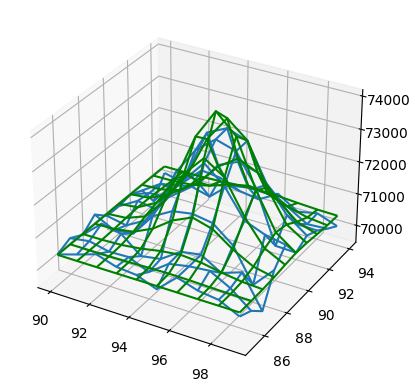

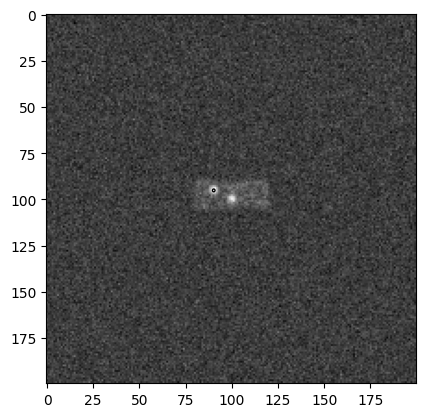

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 100
    # variables        = 6
    chi-square         = 7861325.48
    reduced chi-square = 83631.1221
    Akaike info crit   = 1139.22956
    Bayesian info crit = 1154.86058
[[Variables]]
    height:      3231.00000 +/- 157.534940 (4.88%) (init = 3232)
    centroid_x:  99.7916627 +/- 0.07356430 (0.07%) (init = 100)
    centroid_y:  100.094236 +/- 0.06933280 (0.07%) (init = 100)
    sigma_x:     1.50903959 +/- 0.08299506 (5.50%) (init = 1.6126)
    sigma_y:     1.42223533 +/- 0.07827394 (5.50%) (init = 1.6126)
    background:  70440.8348 +/- 42.0460391 (0.06%) (init = 69903)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma_y, background) = -0.464
    C(sigma_x, background) = -0.462
    C(height, sigma_x)     = -0.439
    C(height, sigma_y)     = -0.438
    C(sigma_x, sigma_y)    = 0.214
None


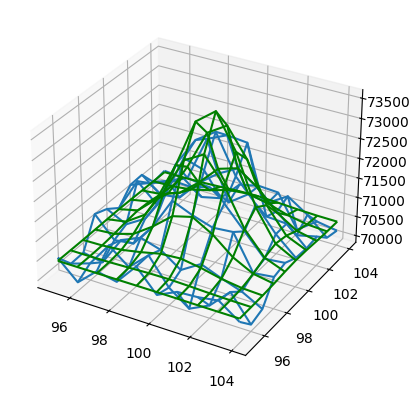

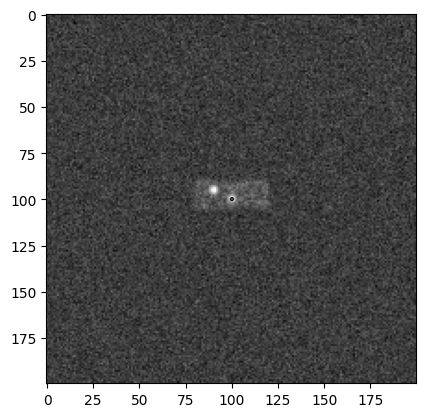

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 16
    # data points      = 100
    # variables        = 6
    chi-square         = 7418055.77
    reduced chi-square = 78915.4869
    Akaike info crit   = 1133.42574
    Bayesian info crit = 1149.05676
[[Variables]]
    height:      1860.86722 +/- 3.1225e+09 (167798486.39%) (init = 1861)
    centroid_x:  181.291538 +/- 1.13424980 (0.63%) (init = 181)
    centroid_y:  73.8878294 +/- 299204.228 (404943.86%) (init = 74)
    sigma_x:     0.40473296 +/- 1.09665623 (270.96%) (init = 0.7071068)
    sigma_y:     0.14769336 +/- 55996.6076 (37914100.29%) (init = 0.7071068)
    background:  70016.1690 +/- 28.8198241 (0.04%) (init = 69231)
[[Correlations]] (unreported correlations are < 0.100)
    C(height, centroid_y)  = -0.995
    C(centroid_x, sigma_x) = -0.976
    C(height, sigma_y)     = -0.676
    C(centroid_y, sigma_y) = 0.595
    C(sigma_y, background) = -0.138
    C(sigma_x, background) = -0.112
None


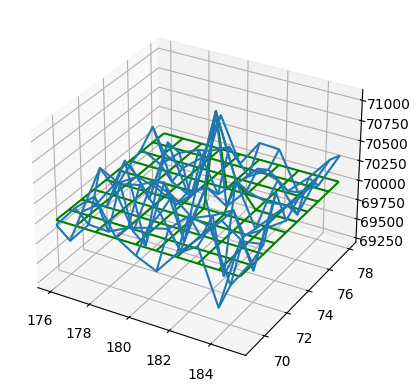

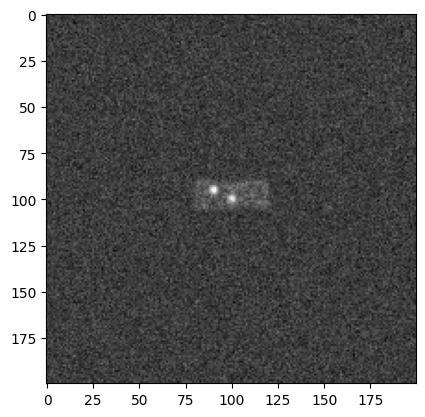

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 100
    # variables        = 6
    chi-square         = 7391277.56
    reduced chi-square = 78630.6124
    Akaike info crit   = 1133.06410
    Bayesian info crit = 1148.69512
[[Variables]]
    height:      1832.57208 +/- 1.2751e+09 (69580688.78%) (init = 1832)
    centroid_x:  56.8700682 +/- 218555.913 (384307.46%) (init = 57)
    centroid_y:  46.9694828 +/- 0.30015711 (0.64%) (init = 47)
    sigma_x:     0.13386918 +/- 201339.559 (150400232.39%) (init = 0.7071068)
    sigma_y:     0.53523486 +/- 0.33161072 (61.96%) (init = 0.7071068)
    background:  70005.4236 +/- 28.5729563 (0.04%) (init = 69316)
[[Correlations]] (unreported correlations are < 0.100)
    C(centroid_x, sigma_x)    = -0.898
    C(height, sigma_y)        = 0.873
    C(centroid_x, sigma_y)    = -0.460
    C(height, centroid_x)     = -0.448
    C(centroid_y, sigma_x)    = 0.313
    C(centroid_x, centroid_y) = -0

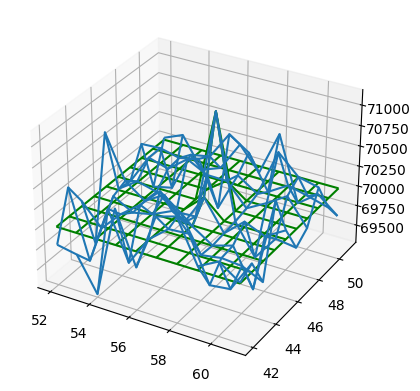

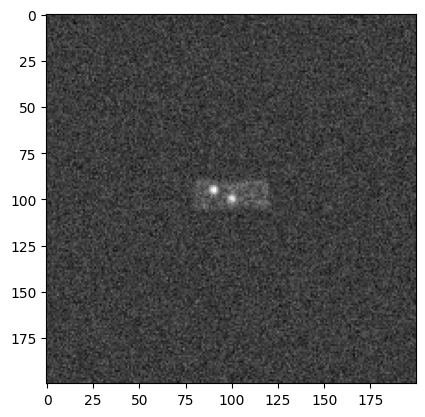

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 100
    # variables        = 6
    chi-square         = 7471286.92
    reduced chi-square = 79481.7758
    Akaike info crit   = 1134.14076
    Bayesian info crit = 1149.77178
[[Variables]]
    height:      1674.99625 +/- 1.1200e+10 (668668446.45%) (init = 1674)
    centroid_x:  146.093121 +/- 1749150.54 (1197284.67%) (init = 146)
    centroid_y:  39.1995209 +/- 20309.3119 (51810.10%) (init = 39)
    sigma_x:     0.16697352 +/- 400066.513 (239598783.64%) (init = 0.7071068)
    sigma_y:     0.23277254 +/- 7864.44362 (3378595.98%) (init = 0.7071068)
    background:  69966.9255 +/- 28.9806965 (0.04%) (init = 69288)
[[Correlations]] (unreported correlations are < 0.100)
    C(centroid_y, sigma_y)    = -1.000
    C(height, centroid_x)     = 1.000
    C(height, sigma_x)        = -1.000
    C(centroid_x, sigma_x)    = -1.000
    C(height, centroid_y)     = 0.996
    C(height, sigma_y)

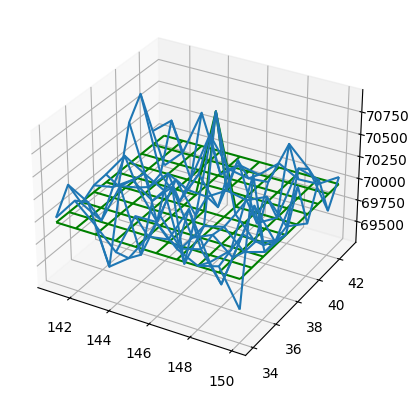

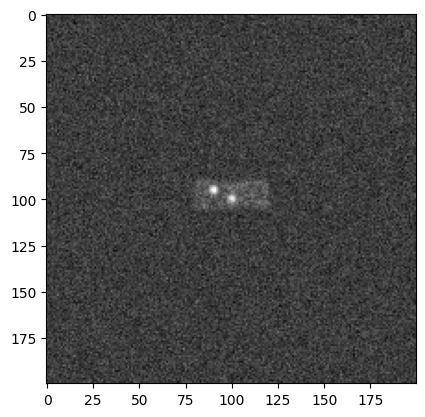

In [7]:
#lets redo this with scale space
#find the sum_projection
sum_projection = np.sum(a['map'],axis=0)
b = blob_detection(path = sum_projection,\
                median= False,\
                threshold= 1e3, \
                min_sigma= 1/np.sqrt(2), \
                max_sigma = 10/np.sqrt(2), \
                num_sigma= 500, \
                overlap = 0, \
                logscale=False,
                verbose=True)
b._update_fitting_parameters(kwargs={"mask_size":5,
                            "plot_fit":True,
                            "fitting_image":"Original",
                            "radius_func":None,
                            "sigma_range":2,
                            "centroid_range":2})
c = b.detection(type = "bp")

<Figure size 640x480 with 0 Axes>

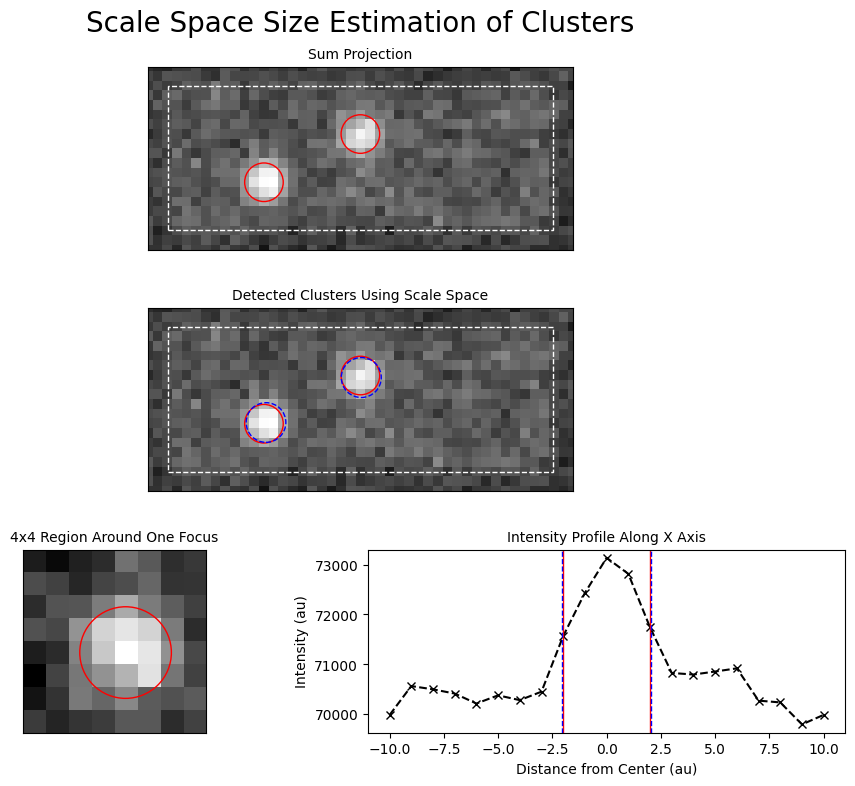

In [8]:
#make a figure with 4X2 subplots using the GS method
plt.clf()
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(4, 2)

#the first subplot is the sum_projection
ax1 = fig.add_subplot(gs[0,:])
ax1.imshow(sum_projection,cmap="gray")
ax1.set_title("Sum Projection",fontsize=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect('equal', 'box')
#make the rectangle around the cell space and the foci
rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
ax1.add_artist(rect)
for j in range(len(initial_dict["initial_centers"])):
    circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax1.add_artist(circle)
#limit the x and y axis to the cell space +- 2
ax1.set_xlim(cell_parms["cell_space"][0]-2,cell_parms["cell_space"][1]+2)
ax1.set_ylim(cell_parms["cell_space"][2]-2,cell_parms["cell_space"][3]+2)

#the second subplot is the sum_projection with the blobs detected
ax2 = fig.add_subplot(gs[1,:])
ax2.imshow(sum_projection,cmap="gray")
ax2.set_title("Detected Clusters Using Scale Space",fontsize=10)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'box')
#make the rectangle around the cell space and the foci
rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
ax2.add_artist(rect)
for j in range(len(initial_dict["initial_centers"])):
    circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax2.add_artist(circle)
#limit the x and y axis to the cell space +- 2
ax2.set_xlim(cell_parms["cell_space"][0]-2,cell_parms["cell_space"][1]+2)
ax2.set_ylim(cell_parms["cell_space"][2]-2,cell_parms["cell_space"][3]+2)

for i in range(len(c['Fitted'])):
    #plot the circles with the center and radius from the fitted parameters
    circle = plt.Circle((c['Fitted'][i][1],c['Fitted'][i][0]), np.mean([c['Fitted'][i][2],c['Fitted'][i][3]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax2.add_artist(circle)

#for the next plot, plot a 4x4 region around one of the foci
ax3 = fig.add_subplot(gs[2,0])
ax3.imshow(sum_projection[initial_dict["initial_centers"][0][0]-4:initial_dict["initial_centers"][0][0]+4,initial_dict["initial_centers"][0][1]-4:initial_dict["initial_centers"][0][1]+4],cmap="gray")
ax3.set_title("4x4 Region Around One Focus",fontsize=10)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_aspect('equal', 'box')
#add the foci cirlce
circle = plt.Circle((4,4), initial_dict["initial_scale"][0], color='r', fill=False, linestyle='-',linewidth=1)
ax3.add_artist(circle)

#on the plot next to it plot the intensity profile along the x axis
ax4 = fig.add_subplot(gs[2,1])
#make the x axis from -10 to 10 with 0 being the center of the circle
x = np.linspace(-10,10,21)
#plot the intensity profile
ax4.plot(x,sum_projection[initial_dict["initial_centers"][0][0],initial_dict["initial_centers"][0][1]-10:initial_dict["initial_centers"][0][1]+11],c='k',marker='x',linestyle='--')
ax4.set_title("Intensity Profile Along X Axis",fontsize=10)
#on this plot, add the radius of the circle relative to the center
ax4.axvline(x=initial_dict["initial_scale"][0], color='r', linestyle='-',linewidth=1)
ax4.axvline(x=-initial_dict["initial_scale"][0], color='r', linestyle='-',linewidth=1)
#using c['Fitted'] add the mean radius of the circle
ax4.axvline(x=np.mean([c['Fitted'][0][2],c['Fitted'][0][3]]), color='b', linestyle='--',linewidth=1)
ax4.axvline(x=-np.mean([c['Fitted'][0][2],c['Fitted'][0][3]]), color='b', linestyle='--',linewidth=1)
#ylabel is the intensity (au)
ax4.set_ylabel("Intensity (au)",fontsize=10)
#xlabel is the distance from the center of the circle (au)
ax4.set_xlabel("Distance from Center (au)",fontsize=10)


#make a title for the whole figure as Scale Space Size Estimation of Clusters
fig.suptitle("Scale Space Size Estimation of Clusters",fontsize=20)
SAVE = False
#tight layout
plt.tight_layout()
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_2/DBSCAN_SS_Inputs/Scale_Space_Flow.svg",format='svg',dpi=200)
plt.show()
